In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
#reading in the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "HTRU2.zip") 
unzip("HTRU2.zip")
col_names <- c('Mean_IP', 'Stdev_IP', 'Kurtosis_IP', 'Skewness_IP', 
               'Mean_DM', "Stdev_DM", 'Kurtosis_DM', "Skewness_DM", "Class")
pulsar_data <- read_csv('HTRU_2.csv', col_names)



Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Mean_DM, Stdev_DM, Kur...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Summary stats for each method
pulsar_data_summary <- group_by(pulsar_data, Class) |>
    summarize(avg_mean_ip = mean(Mean_IP), mean_stdev_ip = mean(Stdev_IP), 
              avg_mean_dm = mean(Mean_DM), mean_stdev_dm = mean(Stdev_DM),
             max_ip = max(Mean_IP), min_ip = min(Mean_IP)) |>
    mutate (as.factor(Class)) 

pulsar_data_IP_summary <- select(pulsar_data_summary, Class, avg_mean_ip, mean_stdev_ip)
pulsar_data_IP_summary

pulsar_data_DM_summary <- select(pulsar_data_summary, Class, avg_mean_dm, mean_stdev_dm)
pulsar_data_DM_summary



Class,avg_mean_ip,mean_stdev_ip
<dbl>,<dbl>,<dbl>
0,116.56273,47.33974
1,56.69061,38.71060


Class,avg_mean_dm,mean_stdev_dm
<dbl>,<dbl>,<dbl>
0,8.863258,23.28798
1,49.825995,56.46896


In [4]:
#Wrangling the data a bit
options(repr.matrix.max.rows = 6)

pulsar_data_wrangled <- mutate(pulsar_data, Class = as.factor(Class))

pulsar_data_IP <- select(pulsar_data_wrangled, Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Class)
pulsar_data_IP

pulsar_data_DM <- select(pulsar_data_wrangled, Mean_DM, Stdev_DM, Kurtosis_DM, Skewness_DM, Class)
pulsar_data_DM



Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,0
102.5078,58.88243,0.4653182,-0.5150879,0
103.0156,39.34165,0.3233284,1.0511644,0
⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,0
114.5078,53.90240,0.2011614,-0.02478884,0
57.0625,85.79734,1.4063910,0.08951971,0


Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.199833,19.11043,7.975532,74.24222,0
1.677258,14.86015,10.576487,127.39358,0
3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮
21.430602,58.87200,2.499517,4.595173,0
1.946488,13.38173,10.007967,134.238910,0
188.306020,64.71256,-1.597527,1.429475,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



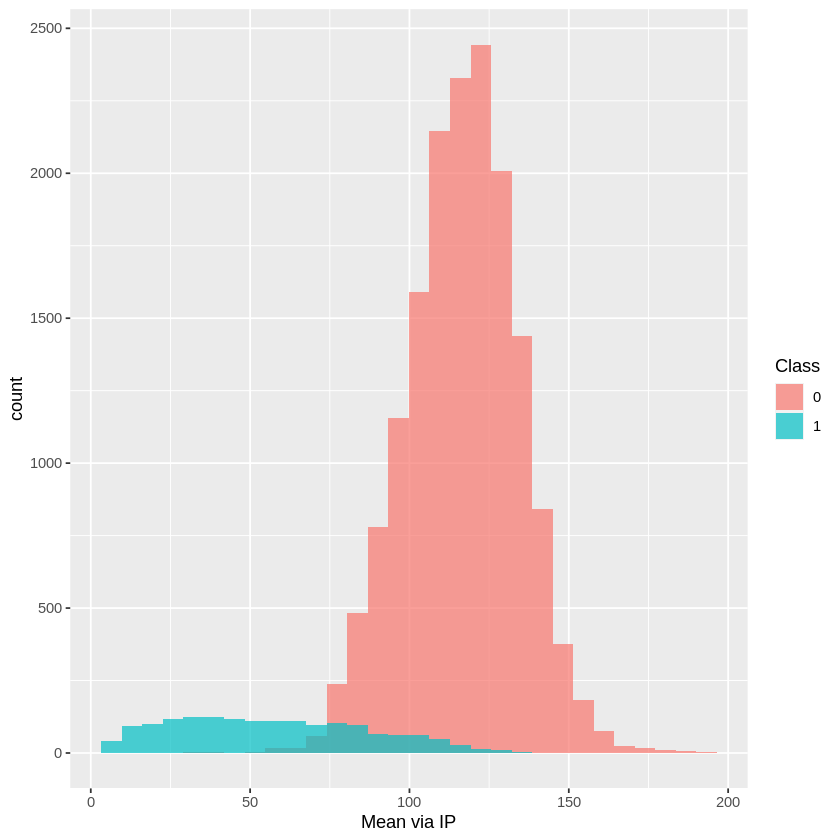

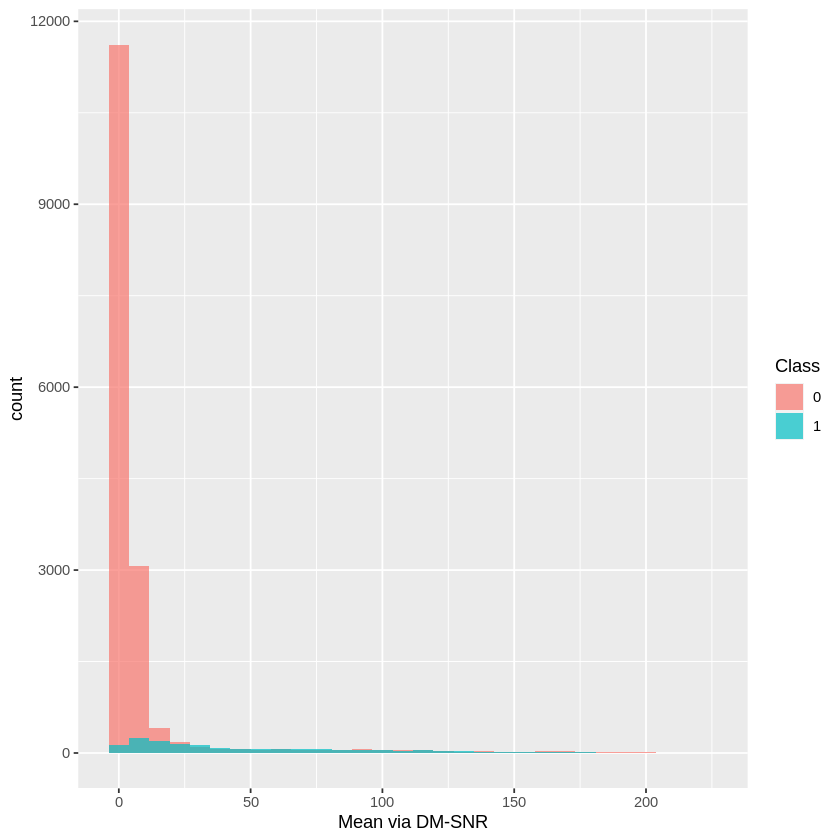

In [7]:
#Basic histograms of means
pulsar_hist_IP <- ggplot(pulsar_data_IP, aes(x = Mean_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity") +
    labs(x = 'Mean via IP')
pulsar_hist_IP

pulsar_hist_DM <- ggplot(pulsar_data_DM, aes(x = Mean_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity") +
    labs(x = 'Mean via DM-SNR')
pulsar_hist_DM

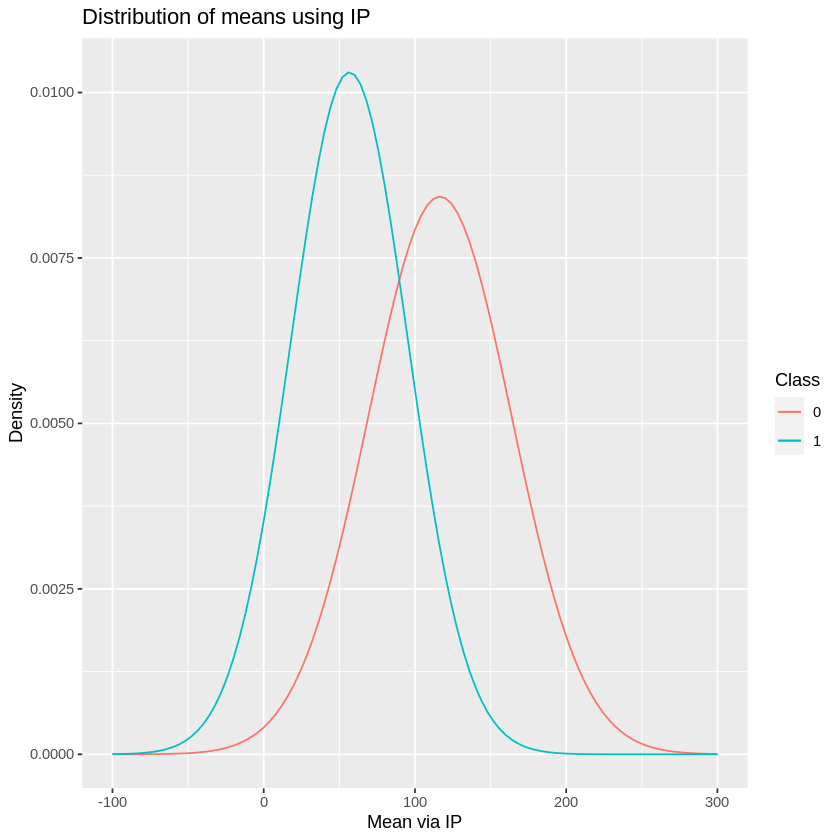

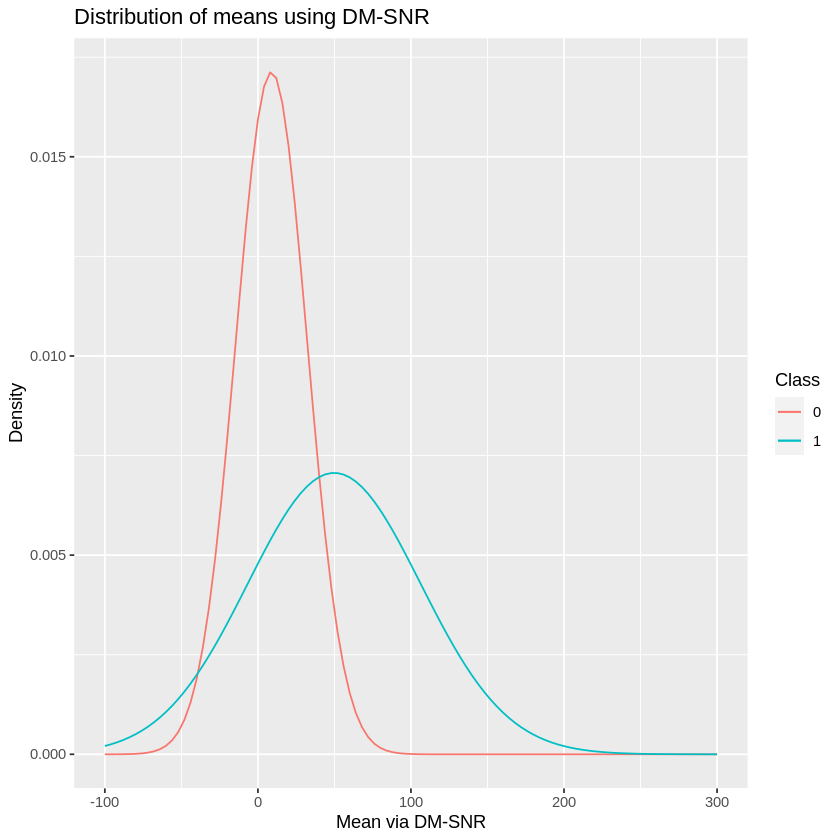

In [9]:
#Normal distribution of avg means of each type
IP_distribution <- ggplot() + 
  lapply(split(pulsar_data_IP_summary, seq_len(nrow(pulsar_data_IP_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_ip, sd = x$mean_stdev_ip), 
                            aes(color = factor(x$Class)))) +
  xlim(-100,300)+
    labs(x = 'Mean via IP', y = 'Density', color = 'Class', 
         title = 'Distribution of means using IP')
IP_distribution

DM_distribution <- ggplot() + 
  lapply(split(pulsar_data_DM_summary, seq_len(nrow(pulsar_data_DM_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_dm, sd = x$mean_stdev_dm), 
                            aes(color = factor(x$Class)))) +
  xlim(-100,300)+
    labs(x = 'Mean via DM-SNR', y = 'Density', color = 'Class', 
         title = 'Distribution of means using DM-SNR')
DM_distribution